In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

np.random.seed(42)


## 2. Generate Synthetic 5-Class Dataset

We will generate a simple synthetic dataset in 2D so that it is easy to visualize.

- Each class will be generated from a 2D Gaussian (normal) distribution with a different mean.
- There will be **5 classes**.
- The total number of samples is configurable.

Using 2D features allows us to:
- Plot the dataset in a scatter plot
- Potentially visualize decision boundaries later (optional)


In [2]:
def generate_5_class_dataset(n_samples_per_class=200):
    """Generate a 2D synthetic dataset with 5 Gaussian clusters (5 classes)."""
    means = [
        (0.0, 0.0),
        (3.0, 0.0),
        (0.0, 3.0),
        (3.0, 3.0),
        (1.5, 1.5),
    ]
    cov = [[0.4, 0.0], [0.0, 0.4]]  # same covariance for all classes

    X_list = []
    y_list = []
    for class_idx, mean in enumerate(means):
        samples = np.random.multivariate_normal(mean, cov, size=n_samples_per_class)
        labels = np.full((n_samples_per_class,), class_idx, dtype=int)
        X_list.append(samples)
        y_list.append(labels)

    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y

# Generate dataset
X, y = generate_5_class_dataset(n_samples_per_class=200)
print('X shape:', X.shape)
print('y shape:', y.shape)
print('Unique classes:', np.unique(y))

# Put into a DataFrame (optional, for inspection)
df = pd.DataFrame(X, columns=['x1', 'x2'])
df['label'] = y
df.head()


X shape: (1000, 2)
y shape: (1000,)
Unique classes: [0 1 2 3 4]


,x1,x2,label
0,0.314150,-0.087446,0
1,0.409634,0.963249,0
2,-0.148092,-0.148081,0
3,0.998782,0.485368,0
4,-0.296922,0.343145,0


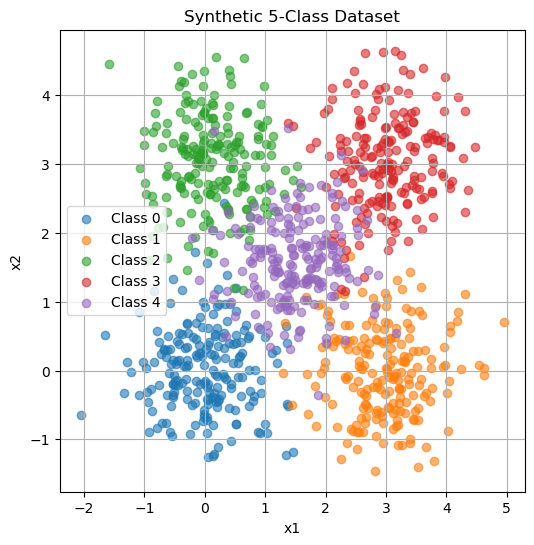

In [3]:
plt.figure(figsize=(6, 6))
for cls in np.unique(y):
    mask = (y == cls)
    plt.scatter(X[mask, 0], X[mask, 1], label=f'Class {cls}', alpha=0.6)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Synthetic 5-Class Dataset')
plt.legend()
plt.grid(True)
plt.show()


## 3. Train/Test Split

We split the dataset into **training (80%)** and **testing (20%)** sets.  
We shuffle the data before splitting.

In [4]:
def train_test_split(X, y, test_ratio=0.2):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    test_size = int(n_samples * test_ratio)
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_ratio=0.2)

print('Train shape:', X_train.shape, y_train.shape)
print('Test shape:', X_test.shape, y_test.shape)


Train shape: (800, 2) (800,)
Test shape: (200, 2) (200,)


## 4. Activation Functions and Helper Utilities

We will use:
- **ReLU** for hidden layers
- **Softmax** for the output layer (multi-class probabilities)
- **Cross-entropy loss** for training

We also define a helper function for one-hot encoding of labels.


In [5]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU with respect to its input z."""
    return (z > 0).astype(float)

def softmax(z):
    """Compute softmax row-wise in a numerically stable way."""
    z_shifted = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_shifted)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def one_hot(y, num_classes):
    """Convert integer labels to one-hot encoding."""
    m = y.shape[0]
    oh = np.zeros((m, num_classes))
    oh[np.arange(m), y] = 1.0
    return oh

def cross_entropy_loss(y_true_one_hot, y_pred_proba):
    """Compute average cross-entropy loss."""
    eps = 1e-15
    y_pred_clipped = np.clip(y_pred_proba, eps, 1 - eps)
    log_probs = -np.log(y_pred_clipped)
    loss = np.sum(y_true_one_hot * log_probs) / y_true_one_hot.shape[0]
    return loss


## 5. Three Hidden Layer Neural Network (From Scratch)

We now implement a `NeuralNetwork` class with:

- Input dimension: 2 (from our dataset)  
- Hidden layer 1: `h1_units` neurons (ReLU)  
- Hidden layer 2: `h2_units` neurons (ReLU)  
- Hidden layer 3: `h3_units` neurons (ReLU)  
- Output layer: 5 neurons (one per class) with softmax  

We will implement:

- Weight initialization  
- Forward pass  
- Backward pass (backpropagation)  
- Parameter update using gradient descent  
- Prediction and accuracy functions  


In [11]:
class NeuralNetwork:
    def __init__(self, input_dim, h1_units, h2_units, h3_units, output_dim, learning_rate=0.01):
        self.input_dim = input_dim
        self.h1_units = h1_units
        self.h2_units = h2_units
        self.h3_units = h3_units
        self.output_dim = output_dim
        self.learning_rate = learning_rate

        # He initialization for weights (good for ReLU)
        self.W1 = np.random.randn(input_dim, h1_units) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, h1_units))

        self.W2 = np.random.randn(h1_units, h2_units) * np.sqrt(2.0 / h1_units)
        self.b2 = np.zeros((1, h2_units))

        self.W3 = np.random.randn(h2_units, h3_units) * np.sqrt(2.0 / h2_units)
        self.b3 = np.zeros((1, h3_units))

        self.W4 = np.random.randn(h3_units, output_dim) * np.sqrt(2.0 / h3_units)
        self.b4 = np.zeros((1, output_dim))

    def forward(self, X):
        """Forward pass: compute layer outputs and cache intermediate values."""
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = relu(self.Z1)

        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = relu(self.Z2)

        self.Z3 = self.A2 @ self.W3 + self.b3
        self.A3 = relu(self.Z3)

        self.Z4 = self.A3 @ self.W4 + self.b4
        self.A4 = softmax(self.Z4)  # output probabilities
        return self.A4

    def backward(self, X, y_true_one_hot, y_pred_proba):
        """Backward pass: compute gradients via backpropagation."""
        m = X.shape[0]

        # Output layer error (softmax + cross-entropy derivative)
        dZ4 = (y_pred_proba - y_true_one_hot) / m  # shape: (m, output_dim)
        dW4 = self.A3.T @ dZ4
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        # Backprop into third hidden layer
        dA3 = dZ4 @ self.W4.T
        dZ3 = dA3 * relu_derivative(self.Z3)
        dW3 = self.A2.T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Backprop into second hidden layer
        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * relu_derivative(self.Z2)
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Backprop into first hidden layer
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Gradient descent update
        self.W4 -= self.learning_rate * dW4
        self.b4 -= self.learning_rate * db4

        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def predict_proba(self, X):
        return self.forward(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def accuracy(self, X, y_true):
        y_pred = self.predict(X)
        return np.mean(y_pred == y_true)


## 6. Train the Neural Network and Plot Learning Curves

We train the model using **mini-batch gradient descent** (you can also try full-batch).  
We track the training loss and training accuracy per epoch.


Epoch 1/100 - Loss: 0.7841 - Train Accuracy: 0.6587
Epoch 10/100 - Loss: 0.5146 - Train Accuracy: 0.8375
Epoch 20/100 - Loss: 0.7299 - Train Accuracy: 0.7350
Epoch 30/100 - Loss: 0.3818 - Train Accuracy: 0.8287
Epoch 40/100 - Loss: 0.3245 - Train Accuracy: 0.8775
Epoch 50/100 - Loss: 0.3179 - Train Accuracy: 0.8688
Epoch 60/100 - Loss: 0.3105 - Train Accuracy: 0.8712
Epoch 70/100 - Loss: 0.2844 - Train Accuracy: 0.8838
Epoch 80/100 - Loss: 0.2538 - Train Accuracy: 0.9075
Epoch 90/100 - Loss: 0.2494 - Train Accuracy: 0.9087
Epoch 100/100 - Loss: 0.3881 - Train Accuracy: 0.8275


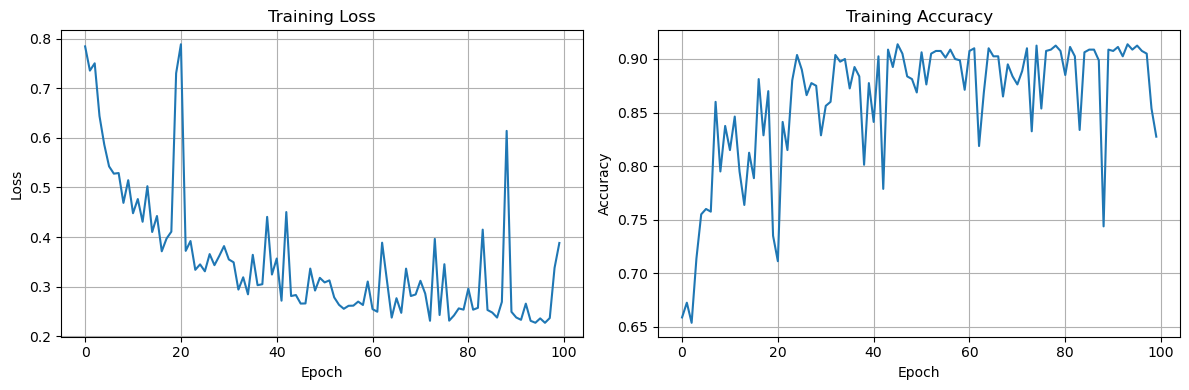

In [7]:
# Hyperparameters
input_dim = X_train.shape[1]
output_dim = len(np.unique(y))
h1_units = 64
h2_units = 32
h3_units = 16
learning_rate = 0.05
epochs = 100
batch_size = 64

nn = NeuralNetwork(input_dim, h1_units, h2_units, h3_units, output_dim, learning_rate=learning_rate)

y_train_oh = one_hot(y_train, output_dim)

loss_history = []
acc_history = []

n_train = X_train.shape[0]
indices = np.arange(n_train)

for epoch in range(epochs):
    # Shuffle training data each epoch
    np.random.shuffle(indices)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    y_train_oh_shuffled = y_train_oh[indices]

    # Mini-batch training
    for start in range(0, n_train, batch_size):
        end = start + batch_size
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_oh_shuffled[start:end]

        # Forward
        y_pred = nn.forward(X_batch)
        # Backward
        nn.backward(X_batch, y_batch, y_pred)

    # End of epoch: compute loss and accuracy on full training set
    y_train_pred_proba = nn.predict_proba(X_train)
    loss = cross_entropy_loss(y_train_oh, y_train_pred_proba)
    acc = nn.accuracy(X_train, y_train)
    loss_history.append(loss)
    acc_history.append(acc)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Train Accuracy: {acc:.4f}")

# Plot loss and accuracy over epochs
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(loss_history)
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid(True)

axs[1].plot(acc_history)
axs[1].set_title('Training Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [8]:
def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def precision_recall_f1_per_class(cm):
    num_classes = cm.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for c in range(num_classes):
        tp = cm[c, c]
        fp = cm[:, c].sum() - tp
        fn = cm[c, :].sum() - tp

        precision[c] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall[c] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        if precision[c] + recall[c] > 0:
            f1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c])
        else:
            f1[c] = 0.0

    return precision, recall, f1

# Predictions on test set
y_test_pred = nn.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, output_dim)
precision, recall, f1 = precision_recall_f1_per_class(cm)
accuracy_test = np.mean(y_test_pred == y_test)

print(f"Test Accuracy: {accuracy_test:.4f}\n")

for c in range(output_dim):
    print(f"Class {c}: Precision={precision[c]:.4f}, Recall={recall[c]:.4f}, F1={f1[c]:.4f}")

print("\nMacro-averaged Precision, Recall, F1:")
print("Precision:", np.mean(precision))
print("Recall   :", np.mean(recall))
print("F1-score :", np.mean(f1))


Test Accuracy: 0.8700

Class 0: Precision=0.9524, Recall=1.0000, F1=0.9756
Class 1: Precision=0.9524, Recall=0.9091, F1=0.9302
Class 2: Precision=0.9773, Recall=0.8776, F1=0.9247
Class 3: Precision=1.0000, Recall=0.6471, F1=0.7857
Class 4: Precision=0.5800, Recall=0.8788, F1=0.6988

Macro-averaged Precision, Recall, F1:
Precision: 0.8924069264069263
Recall   : 0.8624977263632726
F1-score : 0.8630165926939943


### Confusion Matrix Visualization

We visualize the confusion matrix as a heatmap to better understand which classes are confused with each other.


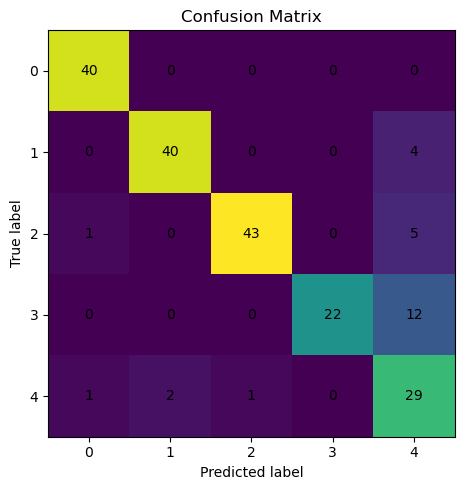

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm)

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

ax.set_xticks(np.arange(output_dim))
ax.set_yticks(np.arange(output_dim))

for i in range(output_dim):
    for j in range(output_dim):
        ax.text(j, i, cm[i, j], ha='center', va='center')

plt.tight_layout()
plt.show()


## 8. Results and Analysis

**Observations:**
- Check the training accuracy curve: does it converge to a high value? If not, consider changing the learning rate, number of epochs, or hidden units.
- Compare per-class precision/recall/F1: are some classes harder to classify?
- The confusion matrix shows where the model makes most mistakes (off-diagonal entries).

**Possible Experiments / Hyperparameters to Try:**
- Change the number of hidden units (e.g., 32–16–8, 128–64–32)
- Change the learning rate (e.g., 0.01, 0.1)
- Increase or decrease the number of epochs
- Use different activation functions (e.g., `tanh`) in hidden layers
- Change the data distribution (e.g., move class means closer/farther)


## 9. Conclusion

In this assignment, we:

- Implemented a **three hidden layer neural network** from scratch for **5-class classification**.
- Generated a synthetic 5-class dataset and performed a **train/test split**.
- Implemented **ReLU** activations, a **softmax** output layer, and **cross-entropy loss**.
- Implemented **backpropagation** manually and trained the network using **mini-batch gradient descent**.
- Evaluated the model with **accuracy, precision, recall, F1-score**, and a **confusion matrix**.

**Challenges & Lessons Learned:**
- Deriving and implementing the gradient formulas correctly is crucial; even small mistakes can prevent learning.
- Proper initialization (e.g., He initialization) and choice of learning rate strongly affect convergence.
- Implementing metrics manually helps deepen understanding of how they are computed and interpreted.

**Potential Improvements:**
- Use more advanced optimization methods (e.g., momentum, Adam) instead of plain gradient descent.
- Add regularization (L2 weight decay, dropout) for more complex datasets.
- Extend the code to handle more complex inputs (e.g., images) and deeper architectures.
